# Vanilla Generative Adversarial Network


In [1]:
import torch
import pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [3]:
batch_size= 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

trainset = MNIST('./data/', train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [4]:
#Example: Normalized image. Values in [-1,1]
img, _ = next(iter(trainloader))

shw = plt.imshow(img[0].permute(1,2,0), cmap='gray')
plt.colorbar(shw)
plt.show()

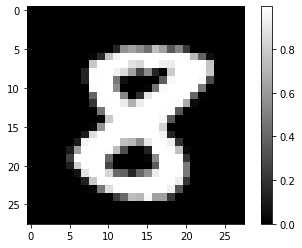

In [5]:
#Example: Denormalized image. Values in [0,1]
def denormalize(x):
    x = (x + 1) / 2
    return x

shw = plt.imshow(denormalize(img[0].permute(1,2,0)), cmap='gray')
plt.colorbar(shw)
plt.show()

## GAN

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size=64, output_size=784, hidden_size=256):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.BatchNorm1d(output_size),
            nn.ReLU(),
            
            nn.Linear(hidden_size, hidden_size),
            #nn.BatchNorm1d(output_size),
            nn.ReLU(),

            nn.Linear(hidden_size, output_size),
            nn.Tanh())

    def forward(self, x):
        return self.generator(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size=784, hidden_size=256):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3),

            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3),
            
            nn.Linear(hidden_size, 1))
    
    def forward(self, x):
        return self.discriminator(x)

In [8]:
def noise_generator(batch_size, latent_size):
    return torch.randn(batch_size, latent_size).to(device)

In [9]:
# Testing Generator
generator = Generator(input_size = 64, #latent_size
                      output_size = 784, #image_size
                      hidden_size = 256).to(device)

noise_vector = noise_generator(1, 64)
#noise_vector: [1, 64]
fake_img = generator(noise_vector)
#fake_img: [1, 784]
fake_img = denormalize(fake_img.detach().cpu().view(-1, 28, 28))
plt.imshow(fake_img[0], cmap='gray')
plt.show()

## Training

In [10]:
def train_discriminator(real_img, num_samples):
    #real_img: [batch_size, 784]

    discriminator.train()

    #Loss for real images
    pred_real =  discriminator(real_img)
    target_real = torch.ones_like(pred_real).to(device)
    d_loss_real = criterion(pred_real, target_real)

    #Loss for fake images
    noise_vector = noise_generator(num_samples, latent_size)
    fake_img = generator(noise_vector)
    pred_fake = discriminator(fake_img.detach())
    target_fake = torch.zeros_like(pred_fake)
    d_loss_fake = criterion(pred_fake, target_fake)

    d_loss = (d_loss_real + d_loss_fake)

    #Backprop and optimize
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss

In [11]:
def train_generator(num_samples):
    generator.train()
    #Loss for fake images
    noise_vector = noise_generator(num_samples, latent_size)
    fake_img = generator(noise_vector)
    pred = discriminator(fake_img)
    target = torch.ones_like(pred).to(device)
    g_loss = criterion(pred, target)

    #Backprop and optimize
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss

In [12]:
#Parameters and hyperparameters
epochs = 300
latent_size = 64
lr = 2e-4
hidden_size = 256
image_size = 784

In [13]:
generator = Generator(input_size = latent_size,
                      output_size = image_size,
                      hidden_size = hidden_size).to(device)
discriminator = Discriminator(input_size = image_size,
                              hidden_size = hidden_size).to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr) #betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr) #betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()

In [14]:
import os

output_dir = 'outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [15]:
#Save some real images
from torchvision.utils import save_image

img, _ = next(iter(trainloader))
save_image(denormalize(img), os.path.join(output_dir, 'real_images.png'), nrow=10)

img = plt.imread(os.path.join(output_dir, 'real_images.png'))
plt.imshow(img, cmap='gray')
plt.show()

In [16]:
#Save fake images before training 
test_noise = noise_generator(batch_size, latent_size)

def save_fake_images(idx):
    fake_img = generator(test_noise)
    fake_img = denormalize(fake_img.detach().cpu().view(-1, 1, 28, 28))
    file_name = "fake_images-{0:0=4d}.png".format(idx)
    save_image(fake_img, os.path.join(output_dir, file_name), nrow=10)

save_fake_images(0)
img = plt.imread(os.path.join(output_dir, "fake_images-{0:0=4d}.png".format(0)))
plt.imshow(img, cmap='gray')
plt.show()

100%|██████████| 600/600 [00:17<00:00, 33.56it/s]


Epoch: 1/300, g_loss: 3.958167552947998, d_loss: 0.236627995967865


100%|██████████| 600/600 [00:16<00:00, 36.22it/s]


Epoch: 2/300, g_loss: 4.642431259155273, d_loss: 0.2372017204761505


100%|██████████| 600/600 [00:15<00:00, 37.69it/s]


Epoch: 3/300, g_loss: 3.8143351078033447, d_loss: 0.3883506655693054


100%|██████████| 600/600 [00:15<00:00, 38.40it/s]


Epoch: 4/300, g_loss: 3.4237730503082275, d_loss: 0.49095746874809265


100%|██████████| 600/600 [00:15<00:00, 38.09it/s]


Epoch: 5/300, g_loss: 3.112819194793701, d_loss: 0.610790491104126


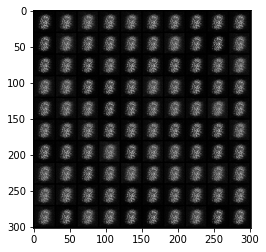

100%|██████████| 600/600 [00:17<00:00, 34.02it/s]


Epoch: 6/300, g_loss: 3.0320451259613037, d_loss: 0.35707294940948486


100%|██████████| 600/600 [00:15<00:00, 38.35it/s]


Epoch: 7/300, g_loss: 3.292275905609131, d_loss: 0.4408867359161377


100%|██████████| 600/600 [00:15<00:00, 38.35it/s]


Epoch: 8/300, g_loss: 3.0576391220092773, d_loss: 0.4409693479537964


100%|██████████| 600/600 [00:16<00:00, 36.11it/s]


Epoch: 9/300, g_loss: 3.1561763286590576, d_loss: 0.34508728981018066


100%|██████████| 600/600 [00:15<00:00, 38.16it/s]


Epoch: 10/300, g_loss: 3.386101484298706, d_loss: 0.3109757900238037


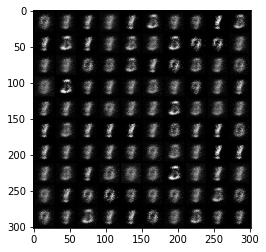

100%|██████████| 600/600 [00:17<00:00, 33.83it/s]


Epoch: 11/300, g_loss: 3.8748512268066406, d_loss: 0.3608669638633728


100%|██████████| 600/600 [00:16<00:00, 35.36it/s]


Epoch: 12/300, g_loss: 3.927246570587158, d_loss: 0.2883561849594116


100%|██████████| 600/600 [00:15<00:00, 38.00it/s]


Epoch: 13/300, g_loss: 4.258511066436768, d_loss: 0.29307496547698975


100%|██████████| 600/600 [00:17<00:00, 34.53it/s]


Epoch: 14/300, g_loss: 5.010676383972168, d_loss: 0.24108070135116577


100%|██████████| 600/600 [00:18<00:00, 32.93it/s]


Epoch: 15/300, g_loss: 4.651384353637695, d_loss: 0.2177910953760147


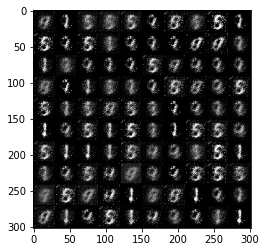

100%|██████████| 600/600 [00:15<00:00, 37.55it/s]


Epoch: 16/300, g_loss: 4.740591526031494, d_loss: 0.23681959509849548


100%|██████████| 600/600 [00:15<00:00, 38.45it/s]


Epoch: 17/300, g_loss: 4.297737121582031, d_loss: 0.2942299246788025


100%|██████████| 600/600 [00:15<00:00, 38.58it/s]


Epoch: 18/300, g_loss: 4.1665825843811035, d_loss: 0.31856903433799744


100%|██████████| 600/600 [00:18<00:00, 32.28it/s]


Epoch: 19/300, g_loss: 4.171937465667725, d_loss: 0.27406173944473267


100%|██████████| 600/600 [00:16<00:00, 35.30it/s]


Epoch: 20/300, g_loss: 4.039997577667236, d_loss: 0.2832042872905731


100%|██████████| 600/600 [00:16<00:00, 35.61it/s]


Epoch: 21/300, g_loss: 4.1986775398254395, d_loss: 0.27741938829421997


100%|██████████| 600/600 [00:17<00:00, 34.26it/s]


Epoch: 22/300, g_loss: 5.284524440765381, d_loss: 0.2533128261566162


100%|██████████| 600/600 [00:18<00:00, 32.84it/s]


Epoch: 23/300, g_loss: 5.147494316101074, d_loss: 0.2341245412826538


100%|██████████| 600/600 [00:17<00:00, 33.91it/s]


Epoch: 24/300, g_loss: 4.611498832702637, d_loss: 0.29013368487358093


100%|██████████| 600/600 [00:15<00:00, 38.17it/s]


Epoch: 25/300, g_loss: 4.096701145172119, d_loss: 0.2878642678260803


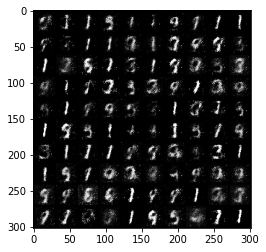

100%|██████████| 600/600 [00:15<00:00, 38.05it/s]


Epoch: 26/300, g_loss: 3.956056833267212, d_loss: 0.33575448393821716


100%|██████████| 600/600 [00:16<00:00, 37.37it/s]


Epoch: 27/300, g_loss: 4.036000728607178, d_loss: 0.3589315712451935


100%|██████████| 600/600 [00:17<00:00, 33.67it/s]


Epoch: 28/300, g_loss: 4.073320388793945, d_loss: 0.3226993680000305


100%|██████████| 600/600 [00:17<00:00, 34.48it/s]


Epoch: 29/300, g_loss: 3.8904483318328857, d_loss: 0.37029141187667847


100%|██████████| 600/600 [00:17<00:00, 34.46it/s]


Epoch: 30/300, g_loss: 4.068378448486328, d_loss: 0.33266276121139526


100%|██████████| 600/600 [00:16<00:00, 36.97it/s]


Epoch: 31/300, g_loss: 4.407534599304199, d_loss: 0.30567365884780884


100%|██████████| 600/600 [00:15<00:00, 38.22it/s]


Epoch: 32/300, g_loss: 4.168729305267334, d_loss: 0.32327455282211304


100%|██████████| 600/600 [00:16<00:00, 36.32it/s]


Epoch: 33/300, g_loss: 3.712885856628418, d_loss: 0.380403071641922


100%|██████████| 600/600 [00:16<00:00, 36.11it/s]


Epoch: 34/300, g_loss: 3.4802608489990234, d_loss: 0.4447019100189209


100%|██████████| 600/600 [00:15<00:00, 38.49it/s]


Epoch: 35/300, g_loss: 3.42781400680542, d_loss: 0.45607393980026245


100%|██████████| 600/600 [00:15<00:00, 38.04it/s]


Epoch: 36/300, g_loss: 3.076925277709961, d_loss: 0.49165570735931396


100%|██████████| 600/600 [00:15<00:00, 38.11it/s]


Epoch: 37/300, g_loss: 3.0284230709075928, d_loss: 0.45861247181892395


100%|██████████| 600/600 [00:15<00:00, 38.51it/s]


Epoch: 38/300, g_loss: 3.205770254135132, d_loss: 0.4508327841758728


100%|██████████| 600/600 [00:15<00:00, 38.58it/s]


Epoch: 39/300, g_loss: 3.3523354530334473, d_loss: 0.4479302167892456


100%|██████████| 600/600 [00:15<00:00, 38.73it/s]


Epoch: 40/300, g_loss: 3.877889394760132, d_loss: 0.3788004517555237


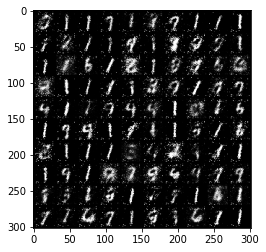

100%|██████████| 600/600 [00:15<00:00, 38.55it/s]


Epoch: 41/300, g_loss: 4.207510948181152, d_loss: 0.3260250687599182


100%|██████████| 600/600 [00:15<00:00, 38.44it/s]


Epoch: 42/300, g_loss: 3.7603604793548584, d_loss: 0.3967619836330414


100%|██████████| 600/600 [00:15<00:00, 38.30it/s]


Epoch: 43/300, g_loss: 3.2497341632843018, d_loss: 0.4673595428466797


100%|██████████| 600/600 [00:16<00:00, 36.06it/s]


Epoch: 44/300, g_loss: 2.998462438583374, d_loss: 0.5366928577423096


100%|██████████| 600/600 [00:18<00:00, 33.06it/s]


Epoch: 45/300, g_loss: 2.7878732681274414, d_loss: 0.5568237900733948


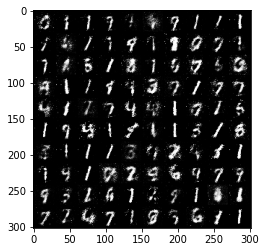

100%|██████████| 600/600 [00:19<00:00, 30.90it/s]


Epoch: 46/300, g_loss: 2.6841537952423096, d_loss: 0.5711649060249329


100%|██████████| 600/600 [00:16<00:00, 35.38it/s]


Epoch: 47/300, g_loss: 2.5631954669952393, d_loss: 0.6043919920921326


100%|██████████| 600/600 [00:17<00:00, 33.36it/s]


Epoch: 48/300, g_loss: 2.5889179706573486, d_loss: 0.5788925886154175


100%|██████████| 600/600 [00:18<00:00, 32.45it/s]


Epoch: 49/300, g_loss: 2.642287492752075, d_loss: 0.5804616808891296


100%|██████████| 600/600 [00:18<00:00, 32.21it/s]


Epoch: 50/300, g_loss: 2.6724188327789307, d_loss: 0.5674679279327393


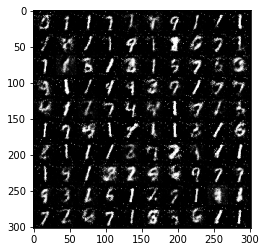

100%|██████████| 600/600 [00:24<00:00, 24.90it/s]


Epoch: 51/300, g_loss: 3.0157313346862793, d_loss: 0.5041423439979553


100%|██████████| 600/600 [00:15<00:00, 37.95it/s]


Epoch: 52/300, g_loss: 3.539686918258667, d_loss: 0.4320579469203949


100%|██████████| 600/600 [00:15<00:00, 38.03it/s]


Epoch: 53/300, g_loss: 3.5822319984436035, d_loss: 0.4189123511314392


100%|██████████| 600/600 [00:16<00:00, 36.70it/s]


Epoch: 54/300, g_loss: 3.036353588104248, d_loss: 0.5157507061958313


100%|██████████| 600/600 [00:16<00:00, 36.11it/s]


Epoch: 55/300, g_loss: 2.72816801071167, d_loss: 0.5807806253433228


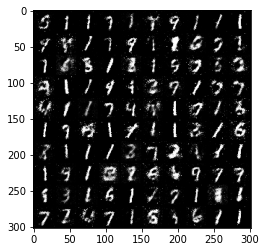

100%|██████████| 600/600 [00:15<00:00, 37.74it/s]


Epoch: 56/300, g_loss: 2.5354907512664795, d_loss: 0.6144914031028748


100%|██████████| 600/600 [00:15<00:00, 37.89it/s]


Epoch: 57/300, g_loss: 2.4542553424835205, d_loss: 0.6410582065582275


100%|██████████| 600/600 [00:18<00:00, 32.69it/s]


Epoch: 58/300, g_loss: 2.361656904220581, d_loss: 0.657618522644043


100%|██████████| 600/600 [00:16<00:00, 37.47it/s]


Epoch: 59/300, g_loss: 2.317709445953369, d_loss: 0.6641774773597717


100%|██████████| 600/600 [00:18<00:00, 32.30it/s]


Epoch: 60/300, g_loss: 2.3269481658935547, d_loss: 0.6440863609313965


100%|██████████| 600/600 [00:16<00:00, 35.84it/s]


Epoch: 61/300, g_loss: 2.3989174365997314, d_loss: 0.6520609855651855


100%|██████████| 600/600 [00:15<00:00, 37.93it/s]


Epoch: 62/300, g_loss: 2.510128974914551, d_loss: 0.6046096682548523


100%|██████████| 600/600 [00:17<00:00, 33.75it/s]


Epoch: 63/300, g_loss: 2.5995969772338867, d_loss: 0.6036263704299927


100%|██████████| 600/600 [00:15<00:00, 37.63it/s]


Epoch: 64/300, g_loss: 2.612595319747925, d_loss: 0.6063454151153564


100%|██████████| 600/600 [00:15<00:00, 37.83it/s]


Epoch: 65/300, g_loss: 2.564671039581299, d_loss: 0.6018572449684143


100%|██████████| 600/600 [00:15<00:00, 37.94it/s]


Epoch: 66/300, g_loss: 2.490139961242676, d_loss: 0.6118502616882324


100%|██████████| 600/600 [00:15<00:00, 38.21it/s]


Epoch: 67/300, g_loss: 2.4753596782684326, d_loss: 0.6242494583129883


100%|██████████| 600/600 [00:15<00:00, 37.75it/s]


Epoch: 68/300, g_loss: 2.438417673110962, d_loss: 0.6324608325958252


100%|██████████| 600/600 [00:18<00:00, 31.98it/s]


Epoch: 69/300, g_loss: 2.4050347805023193, d_loss: 0.6486148834228516


100%|██████████| 600/600 [00:15<00:00, 38.04it/s]


Epoch: 70/300, g_loss: 2.336993455886841, d_loss: 0.6644960641860962


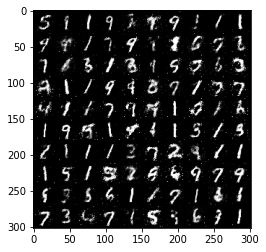

100%|██████████| 600/600 [00:15<00:00, 38.17it/s]


Epoch: 71/300, g_loss: 2.3638901710510254, d_loss: 0.665968656539917


100%|██████████| 600/600 [00:15<00:00, 38.09it/s]


Epoch: 72/300, g_loss: 2.3147521018981934, d_loss: 0.6714587807655334


100%|██████████| 600/600 [00:15<00:00, 38.06it/s]


Epoch: 73/300, g_loss: 2.277986526489258, d_loss: 0.6516565084457397


100%|██████████| 600/600 [00:16<00:00, 36.72it/s]


Epoch: 74/300, g_loss: 2.2673721313476562, d_loss: 0.6623490452766418


100%|██████████| 600/600 [00:15<00:00, 37.96it/s]


Epoch: 75/300, g_loss: 2.301172971725464, d_loss: 0.6560364961624146


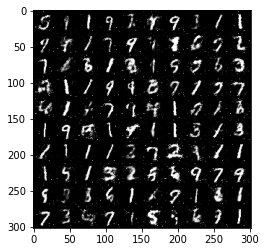

100%|██████████| 600/600 [00:15<00:00, 37.53it/s]


Epoch: 76/300, g_loss: 2.3736767768859863, d_loss: 0.6450962424278259


100%|██████████| 600/600 [00:15<00:00, 38.28it/s]


Epoch: 77/300, g_loss: 2.380589008331299, d_loss: 0.6438148021697998


100%|██████████| 600/600 [00:16<00:00, 37.38it/s]


Epoch: 78/300, g_loss: 2.4739863872528076, d_loss: 0.6487137079238892


100%|██████████| 600/600 [00:15<00:00, 37.90it/s]


Epoch: 79/300, g_loss: 2.295797109603882, d_loss: 0.6804389357566833


100%|██████████| 600/600 [00:15<00:00, 38.23it/s]


Epoch: 80/300, g_loss: 2.213385820388794, d_loss: 0.7263954281806946


100%|██████████| 600/600 [00:16<00:00, 36.43it/s]


Epoch: 81/300, g_loss: 2.1708054542541504, d_loss: 0.7151732444763184


100%|██████████| 600/600 [00:15<00:00, 38.35it/s]


Epoch: 82/300, g_loss: 2.1118245124816895, d_loss: 0.726972758769989


100%|██████████| 600/600 [00:15<00:00, 38.17it/s]


Epoch: 83/300, g_loss: 2.091806650161743, d_loss: 0.7448962330818176


100%|██████████| 600/600 [00:15<00:00, 38.29it/s]


Epoch: 84/300, g_loss: 2.0802125930786133, d_loss: 0.7345689535140991


100%|██████████| 600/600 [00:16<00:00, 36.69it/s]


Epoch: 85/300, g_loss: 2.07411789894104, d_loss: 0.7500436305999756


100%|██████████| 600/600 [00:16<00:00, 36.62it/s]


Epoch: 86/300, g_loss: 2.0400304794311523, d_loss: 0.7577822804450989


100%|██████████| 600/600 [00:24<00:00, 24.13it/s]


Epoch: 87/300, g_loss: 1.9614382982254028, d_loss: 0.7650453448295593


100%|██████████| 600/600 [00:17<00:00, 34.92it/s]


Epoch: 88/300, g_loss: 1.9960600137710571, d_loss: 0.7703660726547241


100%|██████████| 600/600 [00:15<00:00, 37.70it/s]


Epoch: 89/300, g_loss: 2.0725998878479004, d_loss: 0.7520673871040344


100%|██████████| 600/600 [00:15<00:00, 38.63it/s]


Epoch: 90/300, g_loss: 2.029855966567993, d_loss: 0.768082320690155


100%|██████████| 600/600 [00:16<00:00, 36.43it/s]


Epoch: 91/300, g_loss: 1.9746527671813965, d_loss: 0.7732274532318115


100%|██████████| 600/600 [00:15<00:00, 38.02it/s]


Epoch: 92/300, g_loss: 2.009742498397827, d_loss: 0.7795159816741943


100%|██████████| 600/600 [00:15<00:00, 38.12it/s]


Epoch: 93/300, g_loss: 2.0175304412841797, d_loss: 0.7686004042625427


100%|██████████| 600/600 [00:15<00:00, 38.26it/s]


Epoch: 94/300, g_loss: 2.018902540206909, d_loss: 0.7802028059959412


100%|██████████| 600/600 [00:15<00:00, 38.38it/s]


Epoch: 95/300, g_loss: 1.9371403455734253, d_loss: 0.7845110893249512


100%|██████████| 600/600 [00:15<00:00, 38.29it/s]


Epoch: 96/300, g_loss: 1.995044231414795, d_loss: 0.7756580114364624


100%|██████████| 600/600 [00:15<00:00, 38.35it/s]


Epoch: 97/300, g_loss: 2.008171796798706, d_loss: 0.7866098880767822


100%|██████████| 600/600 [00:15<00:00, 38.35it/s]


Epoch: 98/300, g_loss: 1.881280541419983, d_loss: 0.7966592907905579


100%|██████████| 600/600 [00:16<00:00, 36.66it/s]


Epoch: 99/300, g_loss: 1.9403071403503418, d_loss: 0.8014785647392273


100%|██████████| 600/600 [00:15<00:00, 38.62it/s]


Epoch: 100/300, g_loss: 1.8713910579681396, d_loss: 0.812885046005249


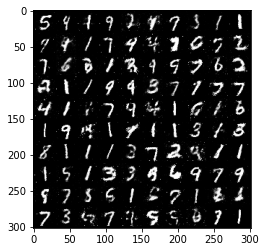

100%|██████████| 600/600 [00:15<00:00, 38.93it/s]


Epoch: 101/300, g_loss: 1.8775626420974731, d_loss: 0.8076133728027344


100%|██████████| 600/600 [00:15<00:00, 38.46it/s]


Epoch: 102/300, g_loss: 1.863673210144043, d_loss: 0.8262339234352112


100%|██████████| 600/600 [00:15<00:00, 38.23it/s]


Epoch: 103/300, g_loss: 1.8367516994476318, d_loss: 0.83390873670578


100%|██████████| 600/600 [00:15<00:00, 37.69it/s]


Epoch: 104/300, g_loss: 1.8187140226364136, d_loss: 0.8298084139823914


100%|██████████| 600/600 [00:15<00:00, 38.48it/s]


Epoch: 105/300, g_loss: 1.8677787780761719, d_loss: 0.8155390024185181


100%|██████████| 600/600 [00:15<00:00, 38.39it/s]


Epoch: 106/300, g_loss: 1.8585838079452515, d_loss: 0.8239105939865112


100%|██████████| 600/600 [00:15<00:00, 38.37it/s]


Epoch: 107/300, g_loss: 1.8588379621505737, d_loss: 0.823848307132721


100%|██████████| 600/600 [00:15<00:00, 37.91it/s]


Epoch: 108/300, g_loss: 1.8302773237228394, d_loss: 0.8436600565910339


100%|██████████| 600/600 [00:15<00:00, 37.60it/s]


Epoch: 109/300, g_loss: 1.7981594800949097, d_loss: 0.8404002785682678


100%|██████████| 600/600 [00:15<00:00, 38.43it/s]


Epoch: 110/300, g_loss: 1.7811639308929443, d_loss: 0.8453495502471924


100%|██████████| 600/600 [00:15<00:00, 38.65it/s]


Epoch: 111/300, g_loss: 1.7706758975982666, d_loss: 0.8395916819572449


100%|██████████| 600/600 [00:15<00:00, 38.32it/s]


Epoch: 112/300, g_loss: 1.8125954866409302, d_loss: 0.850833535194397


100%|██████████| 600/600 [00:15<00:00, 38.66it/s]


Epoch: 113/300, g_loss: 1.8218237161636353, d_loss: 0.8418017625808716


100%|██████████| 600/600 [00:15<00:00, 38.56it/s]


Epoch: 114/300, g_loss: 1.7911678552627563, d_loss: 0.8522950410842896


100%|██████████| 600/600 [00:15<00:00, 38.54it/s]


Epoch: 115/300, g_loss: 1.734736680984497, d_loss: 0.8553308248519897


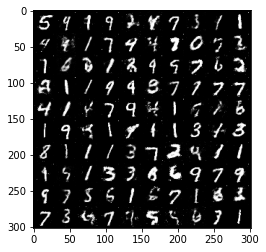

100%|██████████| 600/600 [00:15<00:00, 38.58it/s]


Epoch: 116/300, g_loss: 1.738715410232544, d_loss: 0.8575565814971924


100%|██████████| 600/600 [00:15<00:00, 38.74it/s]


Epoch: 117/300, g_loss: 1.7419829368591309, d_loss: 0.8578175902366638


100%|██████████| 600/600 [00:15<00:00, 38.56it/s]


Epoch: 118/300, g_loss: 1.8011811971664429, d_loss: 0.8488789796829224


100%|██████████| 600/600 [00:15<00:00, 38.69it/s]


Epoch: 119/300, g_loss: 1.8311421871185303, d_loss: 0.8587468862533569


100%|██████████| 600/600 [00:15<00:00, 38.84it/s]


Epoch: 120/300, g_loss: 1.810951590538025, d_loss: 0.8512059450149536


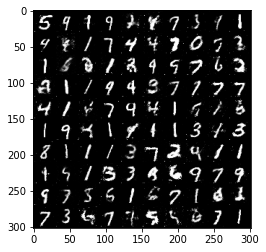

100%|██████████| 600/600 [00:15<00:00, 38.30it/s]


Epoch: 121/300, g_loss: 1.7545961141586304, d_loss: 0.874029278755188


100%|██████████| 600/600 [00:15<00:00, 39.01it/s]


Epoch: 122/300, g_loss: 1.7364137172698975, d_loss: 0.8745154142379761


100%|██████████| 600/600 [00:15<00:00, 38.45it/s]


Epoch: 123/300, g_loss: 1.7139129638671875, d_loss: 0.8745306134223938


100%|██████████| 600/600 [00:15<00:00, 38.08it/s]


Epoch: 124/300, g_loss: 1.6921107769012451, d_loss: 0.8802106976509094


100%|██████████| 600/600 [00:15<00:00, 38.11it/s]


Epoch: 125/300, g_loss: 1.7285822629928589, d_loss: 0.874629557132721


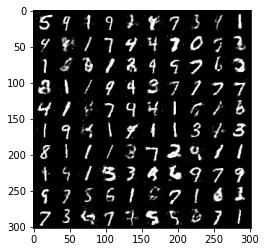

100%|██████████| 600/600 [00:15<00:00, 38.57it/s]


Epoch: 126/300, g_loss: 1.7651625871658325, d_loss: 0.8711233139038086


100%|██████████| 600/600 [00:15<00:00, 38.51it/s]


Epoch: 127/300, g_loss: 1.7671338319778442, d_loss: 0.8668928742408752


100%|██████████| 600/600 [00:15<00:00, 38.48it/s]


Epoch: 128/300, g_loss: 1.7118771076202393, d_loss: 0.8830674290657043


100%|██████████| 600/600 [00:15<00:00, 38.29it/s]


Epoch: 129/300, g_loss: 1.7285693883895874, d_loss: 0.8781201243400574


100%|██████████| 600/600 [00:15<00:00, 38.11it/s]


Epoch: 130/300, g_loss: 1.7263537645339966, d_loss: 0.8796250820159912


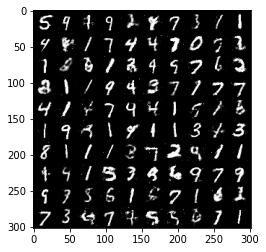

100%|██████████| 600/600 [00:15<00:00, 37.86it/s]


Epoch: 131/300, g_loss: 1.7094157934188843, d_loss: 0.8893623948097229


100%|██████████| 600/600 [00:15<00:00, 38.45it/s]


Epoch: 132/300, g_loss: 1.6353764533996582, d_loss: 0.8991945385932922


100%|██████████| 600/600 [00:15<00:00, 38.44it/s]


Epoch: 133/300, g_loss: 1.6938505172729492, d_loss: 0.8795738816261292


100%|██████████| 600/600 [00:15<00:00, 38.37it/s]


Epoch: 134/300, g_loss: 1.6728261709213257, d_loss: 0.8964945673942566


100%|██████████| 600/600 [00:15<00:00, 38.24it/s]


Epoch: 135/300, g_loss: 1.6562190055847168, d_loss: 0.8967156410217285


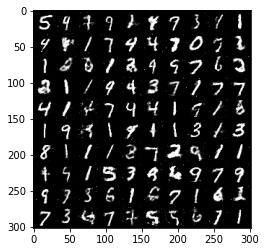

100%|██████████| 600/600 [00:15<00:00, 38.31it/s]


Epoch: 136/300, g_loss: 1.6700133085250854, d_loss: 0.8911661505699158


100%|██████████| 600/600 [00:15<00:00, 37.95it/s]


Epoch: 137/300, g_loss: 1.6534302234649658, d_loss: 0.9036507606506348


100%|██████████| 600/600 [00:15<00:00, 37.84it/s]


Epoch: 138/300, g_loss: 1.6276299953460693, d_loss: 0.8962956070899963


100%|██████████| 600/600 [00:15<00:00, 37.70it/s]


Epoch: 139/300, g_loss: 1.6685619354248047, d_loss: 0.8999513983726501


100%|██████████| 600/600 [00:15<00:00, 38.45it/s]


Epoch: 140/300, g_loss: 1.6875131130218506, d_loss: 0.8980689644813538


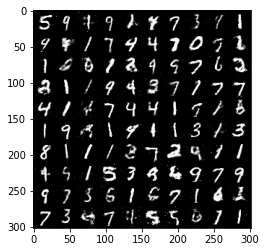

100%|██████████| 600/600 [00:16<00:00, 37.31it/s]


Epoch: 141/300, g_loss: 1.6349880695343018, d_loss: 0.9073392748832703


100%|██████████| 600/600 [00:15<00:00, 37.90it/s]


Epoch: 142/300, g_loss: 1.6462799310684204, d_loss: 0.9128395318984985


100%|██████████| 600/600 [00:15<00:00, 37.75it/s]


Epoch: 143/300, g_loss: 1.6586443185806274, d_loss: 0.8952216506004333


100%|██████████| 600/600 [00:15<00:00, 38.31it/s]


Epoch: 144/300, g_loss: 1.6540570259094238, d_loss: 0.9040801525115967


100%|██████████| 600/600 [00:15<00:00, 38.13it/s]


Epoch: 145/300, g_loss: 1.6407984495162964, d_loss: 0.9120137095451355


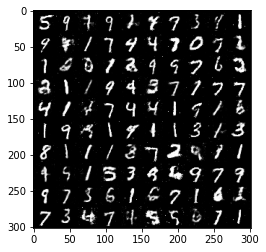

100%|██████████| 600/600 [00:15<00:00, 38.32it/s]


Epoch: 146/300, g_loss: 1.6301172971725464, d_loss: 0.8996621966362


100%|██████████| 600/600 [00:15<00:00, 38.50it/s]


Epoch: 147/300, g_loss: 1.6011308431625366, d_loss: 0.9167988300323486


100%|██████████| 600/600 [00:15<00:00, 38.31it/s]


Epoch: 148/300, g_loss: 1.664151668548584, d_loss: 0.9100509285926819


100%|██████████| 600/600 [00:15<00:00, 38.01it/s]


Epoch: 149/300, g_loss: 1.6305843591690063, d_loss: 0.9203559160232544


100%|██████████| 600/600 [00:15<00:00, 37.99it/s]


Epoch: 150/300, g_loss: 1.5925400257110596, d_loss: 0.9133235812187195


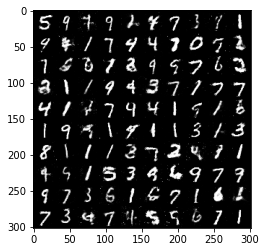

100%|██████████| 600/600 [00:15<00:00, 38.06it/s]


Epoch: 151/300, g_loss: 1.6012970209121704, d_loss: 0.9122502207756042


100%|██████████| 600/600 [00:15<00:00, 38.47it/s]


Epoch: 152/300, g_loss: 1.604114294052124, d_loss: 0.9219500422477722


100%|██████████| 600/600 [00:15<00:00, 38.59it/s]


Epoch: 153/300, g_loss: 1.6118382215499878, d_loss: 0.9178541898727417


100%|██████████| 600/600 [00:15<00:00, 38.21it/s]


Epoch: 154/300, g_loss: 1.6206632852554321, d_loss: 0.9123120307922363


100%|██████████| 600/600 [00:15<00:00, 38.07it/s]


Epoch: 155/300, g_loss: 1.6354379653930664, d_loss: 0.9234872460365295


100%|██████████| 600/600 [00:15<00:00, 38.23it/s]


Epoch: 156/300, g_loss: 1.6050758361816406, d_loss: 0.9215253591537476


100%|██████████| 600/600 [00:15<00:00, 37.91it/s]


Epoch: 157/300, g_loss: 1.621522068977356, d_loss: 0.918590784072876


100%|██████████| 600/600 [00:15<00:00, 38.04it/s]


Epoch: 158/300, g_loss: 1.5794795751571655, d_loss: 0.9260541796684265


100%|██████████| 600/600 [00:15<00:00, 38.03it/s]


Epoch: 159/300, g_loss: 1.581436038017273, d_loss: 0.9268314838409424


100%|██████████| 600/600 [00:16<00:00, 36.63it/s]


Epoch: 160/300, g_loss: 1.5794810056686401, d_loss: 0.9286096692085266


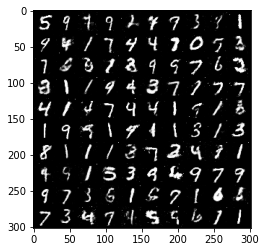

100%|██████████| 600/600 [00:15<00:00, 37.83it/s]


Epoch: 161/300, g_loss: 1.6009362936019897, d_loss: 0.9276863932609558


100%|██████████| 600/600 [00:15<00:00, 38.11it/s]


Epoch: 162/300, g_loss: 1.6059967279434204, d_loss: 0.9361197352409363


100%|██████████| 600/600 [00:15<00:00, 38.20it/s]


Epoch: 163/300, g_loss: 1.5623377561569214, d_loss: 0.9321655035018921


100%|██████████| 600/600 [00:15<00:00, 37.91it/s]


Epoch: 164/300, g_loss: 1.5676716566085815, d_loss: 0.9294151067733765


100%|██████████| 600/600 [00:15<00:00, 38.22it/s]


Epoch: 165/300, g_loss: 1.569793462753296, d_loss: 0.9328768253326416


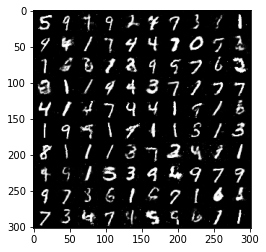

100%|██████████| 600/600 [00:15<00:00, 37.69it/s]


Epoch: 166/300, g_loss: 1.5407475233078003, d_loss: 0.9341674447059631


100%|██████████| 600/600 [00:15<00:00, 38.69it/s]


Epoch: 167/300, g_loss: 1.585220456123352, d_loss: 0.9285071492195129


100%|██████████| 600/600 [00:15<00:00, 38.26it/s]


Epoch: 168/300, g_loss: 1.6164263486862183, d_loss: 0.9285344481468201


100%|██████████| 600/600 [00:15<00:00, 38.40it/s]


Epoch: 169/300, g_loss: 1.6079620122909546, d_loss: 0.9385548830032349


100%|██████████| 600/600 [00:16<00:00, 37.34it/s]


Epoch: 170/300, g_loss: 1.521889567375183, d_loss: 0.9450324177742004


100%|██████████| 600/600 [00:15<00:00, 38.18it/s]


Epoch: 171/300, g_loss: 1.5522162914276123, d_loss: 0.9319085478782654


100%|██████████| 600/600 [00:15<00:00, 38.50it/s]


Epoch: 172/300, g_loss: 1.5593239068984985, d_loss: 0.937110424041748


100%|██████████| 600/600 [00:15<00:00, 37.94it/s]


Epoch: 173/300, g_loss: 1.5728408098220825, d_loss: 0.9290695190429688


100%|██████████| 600/600 [00:15<00:00, 37.97it/s]


Epoch: 174/300, g_loss: 1.5891320705413818, d_loss: 0.922899603843689


100%|██████████| 600/600 [00:15<00:00, 37.75it/s]


Epoch: 175/300, g_loss: 1.5626099109649658, d_loss: 0.941681444644928


100%|██████████| 600/600 [00:15<00:00, 37.97it/s]


Epoch: 176/300, g_loss: 1.581067681312561, d_loss: 0.9391005039215088


100%|██████████| 600/600 [00:15<00:00, 38.16it/s]


Epoch: 177/300, g_loss: 1.5638792514801025, d_loss: 0.936519205570221


100%|██████████| 600/600 [00:15<00:00, 37.71it/s]


Epoch: 178/300, g_loss: 1.5500175952911377, d_loss: 0.9318695068359375


100%|██████████| 600/600 [00:15<00:00, 38.35it/s]


Epoch: 179/300, g_loss: 1.5318328142166138, d_loss: 0.9337236881256104


100%|██████████| 600/600 [00:15<00:00, 37.82it/s]


Epoch: 180/300, g_loss: 1.5941588878631592, d_loss: 0.948219358921051


100%|██████████| 600/600 [00:15<00:00, 38.07it/s]


Epoch: 181/300, g_loss: 1.5548688173294067, d_loss: 0.9366343021392822


100%|██████████| 600/600 [00:15<00:00, 38.06it/s]


Epoch: 182/300, g_loss: 1.5363008975982666, d_loss: 0.946170449256897


100%|██████████| 600/600 [00:15<00:00, 38.40it/s]


Epoch: 183/300, g_loss: 1.5876883268356323, d_loss: 0.9311065673828125


100%|██████████| 600/600 [00:15<00:00, 37.56it/s]


Epoch: 184/300, g_loss: 1.5499229431152344, d_loss: 0.9368341565132141


100%|██████████| 600/600 [00:15<00:00, 38.14it/s]


Epoch: 185/300, g_loss: 1.5418882369995117, d_loss: 0.9412961602210999


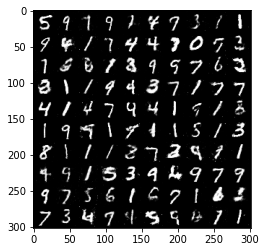

100%|██████████| 600/600 [00:15<00:00, 37.58it/s]


Epoch: 186/300, g_loss: 1.5185092687606812, d_loss: 0.9374302625656128


100%|██████████| 600/600 [00:15<00:00, 38.03it/s]


Epoch: 187/300, g_loss: 1.5725455284118652, d_loss: 0.9413297772407532


100%|██████████| 600/600 [00:15<00:00, 38.16it/s]


Epoch: 188/300, g_loss: 1.5698901414871216, d_loss: 0.9400708079338074


100%|██████████| 600/600 [00:15<00:00, 38.29it/s]


Epoch: 189/300, g_loss: 1.5180779695510864, d_loss: 0.9309174418449402


100%|██████████| 600/600 [00:15<00:00, 37.71it/s]


Epoch: 190/300, g_loss: 1.5269672870635986, d_loss: 0.9474406838417053


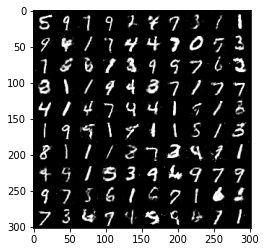

100%|██████████| 600/600 [00:15<00:00, 38.09it/s]


Epoch: 191/300, g_loss: 1.5287421941757202, d_loss: 0.9362719655036926


100%|██████████| 600/600 [00:15<00:00, 38.06it/s]


Epoch: 192/300, g_loss: 1.532812237739563, d_loss: 0.943511962890625


100%|██████████| 600/600 [00:15<00:00, 37.76it/s]


Epoch: 193/300, g_loss: 1.5398311614990234, d_loss: 0.9461621046066284


100%|██████████| 600/600 [00:17<00:00, 34.98it/s]


Epoch: 194/300, g_loss: 1.5428882837295532, d_loss: 0.9433638453483582


100%|██████████| 600/600 [00:16<00:00, 36.91it/s]


Epoch: 195/300, g_loss: 1.5300618410110474, d_loss: 0.9442558884620667


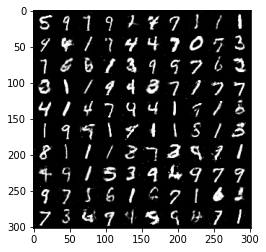

100%|██████████| 600/600 [00:16<00:00, 37.04it/s]


Epoch: 196/300, g_loss: 1.5357756614685059, d_loss: 0.9366257190704346


100%|██████████| 600/600 [00:16<00:00, 37.33it/s]


Epoch: 197/300, g_loss: 1.5343245267868042, d_loss: 0.9421849250793457


100%|██████████| 600/600 [00:16<00:00, 36.96it/s]


Epoch: 198/300, g_loss: 1.5222035646438599, d_loss: 0.9423456192016602


100%|██████████| 600/600 [00:16<00:00, 37.10it/s]


Epoch: 199/300, g_loss: 1.504210114479065, d_loss: 0.9540709853172302


100%|██████████| 600/600 [00:16<00:00, 37.10it/s]


Epoch: 200/300, g_loss: 1.5456005334854126, d_loss: 0.9400896430015564


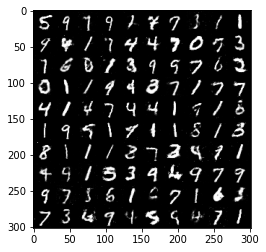

100%|██████████| 600/600 [00:16<00:00, 37.03it/s]


Epoch: 201/300, g_loss: 1.5228780508041382, d_loss: 0.9460650682449341


100%|██████████| 600/600 [00:16<00:00, 36.72it/s]


Epoch: 202/300, g_loss: 1.5476785898208618, d_loss: 0.9448543190956116


100%|██████████| 600/600 [00:16<00:00, 36.30it/s]


Epoch: 203/300, g_loss: 1.5544393062591553, d_loss: 0.9474653005599976


100%|██████████| 600/600 [00:16<00:00, 36.41it/s]


Epoch: 204/300, g_loss: 1.526244044303894, d_loss: 0.9436581134796143


100%|██████████| 600/600 [00:16<00:00, 36.93it/s]


Epoch: 205/300, g_loss: 1.535674810409546, d_loss: 0.9491101503372192


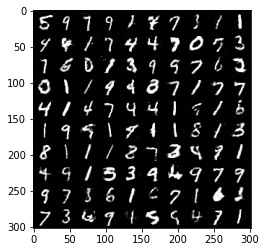

100%|██████████| 600/600 [00:16<00:00, 36.78it/s]


Epoch: 206/300, g_loss: 1.521937370300293, d_loss: 0.9480642676353455


100%|██████████| 600/600 [00:16<00:00, 36.68it/s]


Epoch: 207/300, g_loss: 1.5238571166992188, d_loss: 0.9416378736495972


100%|██████████| 600/600 [00:16<00:00, 36.13it/s]


Epoch: 208/300, g_loss: 1.5135622024536133, d_loss: 0.9427555799484253


100%|██████████| 600/600 [00:16<00:00, 36.39it/s]


Epoch: 209/300, g_loss: 1.531853199005127, d_loss: 0.9431666135787964


100%|██████████| 600/600 [00:16<00:00, 35.72it/s]


Epoch: 210/300, g_loss: 1.5443565845489502, d_loss: 0.9438537359237671


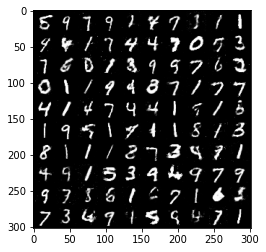

100%|██████████| 600/600 [00:16<00:00, 36.30it/s]


Epoch: 211/300, g_loss: 1.5208452939987183, d_loss: 0.9499514102935791


100%|██████████| 600/600 [00:17<00:00, 34.84it/s]


Epoch: 212/300, g_loss: 1.5000290870666504, d_loss: 0.9421877861022949


100%|██████████| 600/600 [00:16<00:00, 35.62it/s]


Epoch: 213/300, g_loss: 1.5154168605804443, d_loss: 0.9421963095664978


100%|██████████| 600/600 [00:17<00:00, 34.35it/s]


Epoch: 214/300, g_loss: 1.5525989532470703, d_loss: 0.9456450939178467


100%|██████████| 600/600 [00:19<00:00, 30.72it/s]


Epoch: 215/300, g_loss: 1.5370103120803833, d_loss: 0.9499183297157288


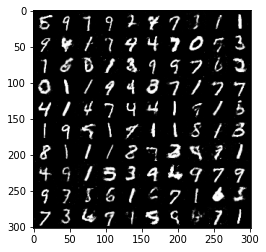

100%|██████████| 600/600 [00:16<00:00, 35.73it/s]


Epoch: 216/300, g_loss: 1.5182321071624756, d_loss: 0.9481443762779236


100%|██████████| 600/600 [00:16<00:00, 35.85it/s]


Epoch: 217/300, g_loss: 1.5341358184814453, d_loss: 0.9372977018356323


100%|██████████| 600/600 [00:16<00:00, 36.08it/s]


Epoch: 218/300, g_loss: 1.5267351865768433, d_loss: 0.9504792094230652


100%|██████████| 600/600 [00:16<00:00, 35.83it/s]


Epoch: 219/300, g_loss: 1.5159169435501099, d_loss: 0.9450263381004333


100%|██████████| 600/600 [00:16<00:00, 35.53it/s]


Epoch: 220/300, g_loss: 1.5442836284637451, d_loss: 0.9414893388748169


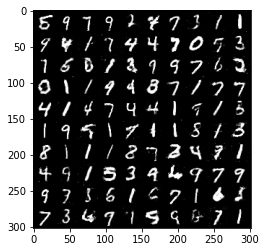

100%|██████████| 600/600 [00:16<00:00, 35.30it/s]


Epoch: 221/300, g_loss: 1.526126742362976, d_loss: 0.9458436369895935


100%|██████████| 600/600 [00:16<00:00, 35.62it/s]


Epoch: 222/300, g_loss: 1.5161681175231934, d_loss: 0.9360882043838501


100%|██████████| 600/600 [00:16<00:00, 35.40it/s]


Epoch: 223/300, g_loss: 1.5045747756958008, d_loss: 0.9432674050331116


100%|██████████| 600/600 [00:16<00:00, 35.84it/s]


Epoch: 224/300, g_loss: 1.5350373983383179, d_loss: 0.9503282308578491


100%|██████████| 600/600 [00:16<00:00, 35.31it/s]


Epoch: 225/300, g_loss: 1.5051969289779663, d_loss: 0.9421321153640747


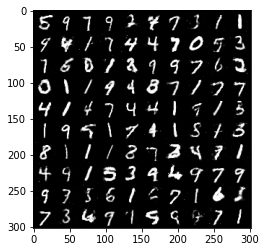

100%|██████████| 600/600 [00:17<00:00, 35.02it/s]


Epoch: 226/300, g_loss: 1.526200532913208, d_loss: 0.943221390247345


100%|██████████| 600/600 [00:16<00:00, 35.70it/s]


Epoch: 227/300, g_loss: 1.5488498210906982, d_loss: 0.9469158053398132


100%|██████████| 600/600 [00:17<00:00, 34.66it/s]


Epoch: 228/300, g_loss: 1.5223584175109863, d_loss: 0.9433114528656006


100%|██████████| 600/600 [00:16<00:00, 37.15it/s]


Epoch: 229/300, g_loss: 1.5411381721496582, d_loss: 0.9454310536384583


100%|██████████| 600/600 [00:16<00:00, 37.14it/s]


Epoch: 230/300, g_loss: 1.5117946863174438, d_loss: 0.9396913647651672


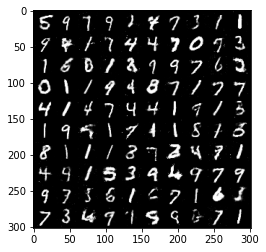

100%|██████████| 600/600 [00:16<00:00, 37.10it/s]


Epoch: 231/300, g_loss: 1.4996577501296997, d_loss: 0.9428957104682922


100%|██████████| 600/600 [00:15<00:00, 37.61it/s]


Epoch: 232/300, g_loss: 1.5158940553665161, d_loss: 0.9485617876052856


100%|██████████| 600/600 [00:16<00:00, 35.37it/s]


Epoch: 233/300, g_loss: 1.5193125009536743, d_loss: 0.9390301704406738


100%|██████████| 600/600 [00:16<00:00, 37.17it/s]


Epoch: 234/300, g_loss: 1.5179468393325806, d_loss: 0.9479876160621643


100%|██████████| 600/600 [00:16<00:00, 36.78it/s]


Epoch: 235/300, g_loss: 1.5213364362716675, d_loss: 0.9466153979301453


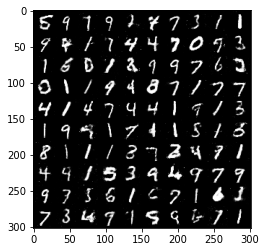

100%|██████████| 600/600 [00:16<00:00, 37.34it/s]


Epoch: 236/300, g_loss: 1.5310298204421997, d_loss: 0.9411484599113464


100%|██████████| 600/600 [00:16<00:00, 37.27it/s]


Epoch: 237/300, g_loss: 1.5314589738845825, d_loss: 0.9426184296607971


100%|██████████| 600/600 [00:16<00:00, 37.21it/s]


Epoch: 238/300, g_loss: 1.544838309288025, d_loss: 0.9482885003089905


100%|██████████| 600/600 [00:16<00:00, 36.91it/s]


Epoch: 239/300, g_loss: 1.5093578100204468, d_loss: 0.9451344013214111


100%|██████████| 600/600 [00:16<00:00, 37.18it/s]


Epoch: 240/300, g_loss: 1.4983386993408203, d_loss: 0.9423637986183167


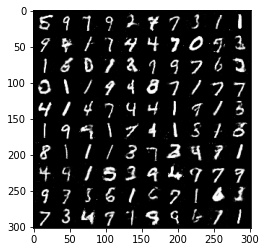

100%|██████████| 600/600 [00:16<00:00, 37.07it/s]


Epoch: 241/300, g_loss: 1.5226093530654907, d_loss: 0.9488698840141296


100%|██████████| 600/600 [00:16<00:00, 37.30it/s]


Epoch: 242/300, g_loss: 1.5351563692092896, d_loss: 0.9348185062408447


100%|██████████| 600/600 [00:16<00:00, 36.99it/s]


Epoch: 243/300, g_loss: 1.5251636505126953, d_loss: 0.9366390109062195


100%|██████████| 600/600 [00:16<00:00, 36.96it/s]


Epoch: 244/300, g_loss: 1.5155277252197266, d_loss: 0.9421378970146179


100%|██████████| 600/600 [00:15<00:00, 37.53it/s]


Epoch: 245/300, g_loss: 1.5128905773162842, d_loss: 0.9429050087928772


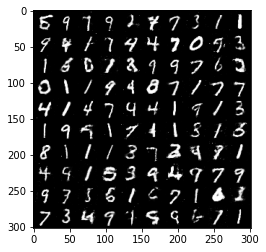

100%|██████████| 600/600 [00:16<00:00, 36.67it/s]


Epoch: 246/300, g_loss: 1.5101522207260132, d_loss: 0.9417374730110168


100%|██████████| 600/600 [00:16<00:00, 37.10it/s]


Epoch: 247/300, g_loss: 1.519565224647522, d_loss: 0.9368996620178223


100%|██████████| 600/600 [00:16<00:00, 35.77it/s]


Epoch: 248/300, g_loss: 1.5191071033477783, d_loss: 0.9421951770782471


100%|██████████| 600/600 [00:16<00:00, 37.21it/s]


Epoch: 249/300, g_loss: 1.5176385641098022, d_loss: 0.9425639510154724


100%|██████████| 600/600 [00:16<00:00, 36.76it/s]


Epoch: 250/300, g_loss: 1.522755742073059, d_loss: 0.9385667443275452


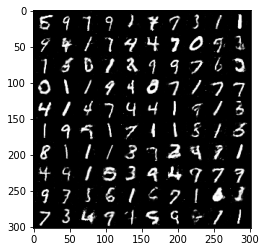

100%|██████████| 600/600 [00:16<00:00, 36.72it/s]


Epoch: 251/300, g_loss: 1.549649715423584, d_loss: 0.9469591975212097


100%|██████████| 600/600 [00:15<00:00, 37.70it/s]


Epoch: 252/300, g_loss: 1.5057125091552734, d_loss: 0.9377146363258362


100%|██████████| 600/600 [00:16<00:00, 36.78it/s]


Epoch: 253/300, g_loss: 1.5068647861480713, d_loss: 0.9414169192314148


100%|██████████| 600/600 [00:16<00:00, 37.25it/s]


Epoch: 254/300, g_loss: 1.5202935934066772, d_loss: 0.941771388053894


100%|██████████| 600/600 [00:16<00:00, 36.46it/s]


Epoch: 255/300, g_loss: 1.521753191947937, d_loss: 0.9403340220451355


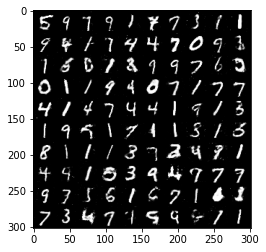

100%|██████████| 600/600 [00:16<00:00, 37.39it/s]


Epoch: 256/300, g_loss: 1.523895263671875, d_loss: 0.9394515752792358


100%|██████████| 600/600 [00:16<00:00, 37.28it/s]


Epoch: 257/300, g_loss: 1.4981355667114258, d_loss: 0.9416447281837463


100%|██████████| 600/600 [00:16<00:00, 37.26it/s]


Epoch: 258/300, g_loss: 1.5439783334732056, d_loss: 0.9368855953216553


100%|██████████| 600/600 [00:16<00:00, 37.28it/s]


Epoch: 259/300, g_loss: 1.5052129030227661, d_loss: 0.9388655424118042


100%|██████████| 600/600 [00:17<00:00, 34.41it/s]


Epoch: 260/300, g_loss: 1.520647406578064, d_loss: 0.9431930184364319


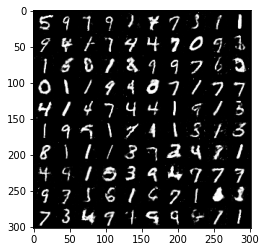

100%|██████████| 600/600 [00:16<00:00, 36.74it/s]


Epoch: 261/300, g_loss: 1.525549292564392, d_loss: 0.9341633319854736


100%|██████████| 600/600 [00:15<00:00, 37.77it/s]


Epoch: 262/300, g_loss: 1.5209294557571411, d_loss: 0.9403926730155945


100%|██████████| 600/600 [00:16<00:00, 37.34it/s]


Epoch: 263/300, g_loss: 1.5003093481063843, d_loss: 0.9415779113769531


100%|██████████| 600/600 [00:16<00:00, 37.44it/s]


Epoch: 264/300, g_loss: 1.5074810981750488, d_loss: 0.9324521422386169


100%|██████████| 600/600 [00:15<00:00, 37.53it/s]


Epoch: 265/300, g_loss: 1.5335382223129272, d_loss: 0.9420385360717773


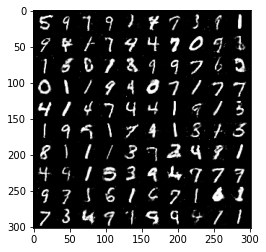

100%|██████████| 600/600 [00:16<00:00, 36.86it/s]


Epoch: 266/300, g_loss: 1.5211211442947388, d_loss: 0.9375783801078796


100%|██████████| 600/600 [00:16<00:00, 37.16it/s]


Epoch: 267/300, g_loss: 1.508927345275879, d_loss: 0.9440248608589172


100%|██████████| 600/600 [00:15<00:00, 37.64it/s]


Epoch: 268/300, g_loss: 1.509341835975647, d_loss: 0.9369266629219055


100%|██████████| 600/600 [00:15<00:00, 37.86it/s]


Epoch: 269/300, g_loss: 1.5199030637741089, d_loss: 0.9408838748931885


100%|██████████| 600/600 [00:16<00:00, 37.42it/s]


Epoch: 270/300, g_loss: 1.5272703170776367, d_loss: 0.9383689165115356


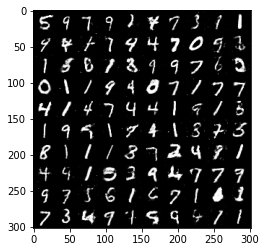

100%|██████████| 600/600 [00:16<00:00, 37.30it/s]


Epoch: 271/300, g_loss: 1.530121922492981, d_loss: 0.9449726343154907


100%|██████████| 600/600 [00:16<00:00, 37.36it/s]


Epoch: 272/300, g_loss: 1.5416055917739868, d_loss: 0.9404821991920471


100%|██████████| 600/600 [00:15<00:00, 37.86it/s]


Epoch: 273/300, g_loss: 1.525272011756897, d_loss: 0.9379699230194092


100%|██████████| 600/600 [00:15<00:00, 37.52it/s]


Epoch: 274/300, g_loss: 1.5278067588806152, d_loss: 0.9377217888832092


100%|██████████| 600/600 [00:16<00:00, 36.95it/s]


Epoch: 275/300, g_loss: 1.523186206817627, d_loss: 0.9431326389312744


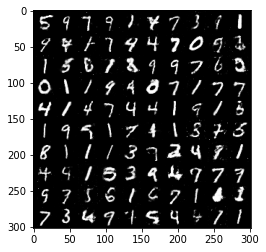

100%|██████████| 600/600 [00:15<00:00, 37.91it/s]


Epoch: 276/300, g_loss: 1.530522108078003, d_loss: 0.9366424679756165


100%|██████████| 600/600 [00:15<00:00, 37.60it/s]


Epoch: 277/300, g_loss: 1.521855354309082, d_loss: 0.9397638440132141


100%|██████████| 600/600 [00:15<00:00, 38.09it/s]


Epoch: 278/300, g_loss: 1.505133867263794, d_loss: 0.9375168681144714


100%|██████████| 600/600 [00:15<00:00, 38.20it/s]


Epoch: 279/300, g_loss: 1.5230590105056763, d_loss: 0.9374059438705444


100%|██████████| 600/600 [00:15<00:00, 37.73it/s]


Epoch: 280/300, g_loss: 1.5261470079421997, d_loss: 0.9379618167877197


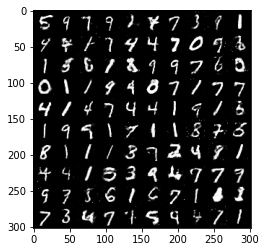

100%|██████████| 600/600 [00:15<00:00, 38.21it/s]


Epoch: 281/300, g_loss: 1.5362404584884644, d_loss: 0.9338394403457642


100%|██████████| 600/600 [00:15<00:00, 37.70it/s]


Epoch: 282/300, g_loss: 1.5169934034347534, d_loss: 0.937581479549408


100%|██████████| 600/600 [00:15<00:00, 38.38it/s]


Epoch: 283/300, g_loss: 1.5282566547393799, d_loss: 0.9354739785194397


100%|██████████| 600/600 [00:15<00:00, 37.63it/s]


Epoch: 284/300, g_loss: 1.5392183065414429, d_loss: 0.9408653974533081


100%|██████████| 600/600 [00:15<00:00, 37.62it/s]


Epoch: 285/300, g_loss: 1.5154223442077637, d_loss: 0.9326126575469971


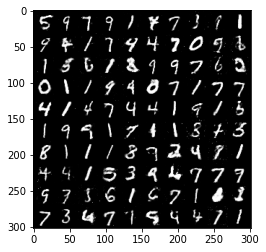

100%|██████████| 600/600 [00:16<00:00, 37.18it/s]


Epoch: 286/300, g_loss: 1.5163211822509766, d_loss: 0.941402792930603


100%|██████████| 600/600 [00:16<00:00, 37.43it/s]


Epoch: 287/300, g_loss: 1.518900752067566, d_loss: 0.9363850951194763


100%|██████████| 600/600 [00:15<00:00, 39.11it/s]


Epoch: 288/300, g_loss: 1.5485663414001465, d_loss: 0.9345905184745789


100%|██████████| 600/600 [00:15<00:00, 38.73it/s]


Epoch: 289/300, g_loss: 1.5274327993392944, d_loss: 0.9437828660011292


100%|██████████| 600/600 [00:15<00:00, 38.64it/s]


Epoch: 290/300, g_loss: 1.5255153179168701, d_loss: 0.9330013990402222


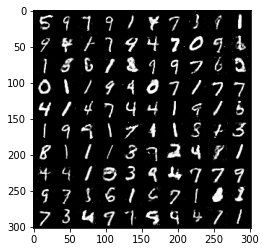

100%|██████████| 600/600 [00:15<00:00, 38.18it/s]


Epoch: 291/300, g_loss: 1.5222032070159912, d_loss: 0.9346632957458496


100%|██████████| 600/600 [00:15<00:00, 38.84it/s]


Epoch: 292/300, g_loss: 1.5329524278640747, d_loss: 0.9323495626449585


100%|██████████| 600/600 [00:15<00:00, 38.92it/s]


Epoch: 293/300, g_loss: 1.5334501266479492, d_loss: 0.9234935641288757


100%|██████████| 600/600 [00:15<00:00, 38.40it/s]


Epoch: 294/300, g_loss: 1.5412368774414062, d_loss: 0.9333657026290894


100%|██████████| 600/600 [00:15<00:00, 38.63it/s]


Epoch: 295/300, g_loss: 1.5361160039901733, d_loss: 0.9307540059089661


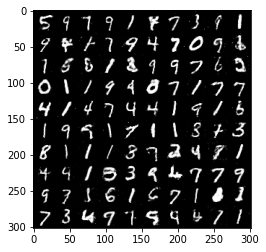

100%|██████████| 600/600 [00:15<00:00, 38.64it/s]


Epoch: 296/300, g_loss: 1.5262075662612915, d_loss: 0.9323078393936157


100%|██████████| 600/600 [00:15<00:00, 38.42it/s]


Epoch: 297/300, g_loss: 1.5107665061950684, d_loss: 0.9280012845993042


100%|██████████| 600/600 [00:15<00:00, 38.74it/s]


Epoch: 298/300, g_loss: 1.5468378067016602, d_loss: 0.9329540133476257


100%|██████████| 600/600 [00:15<00:00, 38.38it/s]


Epoch: 299/300, g_loss: 1.5334179401397705, d_loss: 0.9237498044967651


100%|██████████| 600/600 [00:16<00:00, 37.47it/s]


Epoch: 300/300, g_loss: 1.5123213529586792, d_loss: 0.9276419281959534


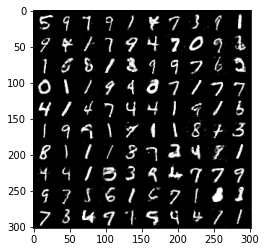

In [17]:
for epoch in range(1, epochs+1):
    mean_g_loss = 0
    mean_d_loss = 0
    for img, _ in tqdm(trainloader):
        #img: [batch_size, 1, 28, 28]
        img = img.view(img.shape[0], -1).to(device)
        #img: [batch_size, 784]
        
        d_loss = train_discriminator(img, img.shape[0])
        g_loss = train_generator(img.shape[0])

        #Stats
        mean_d_loss += d_loss / len(trainloader)
        mean_g_loss += g_loss / len(trainloader)
    
    #Verbose
    print(f"Epoch: {epoch}/{epochs}, g_loss: {mean_g_loss}, d_loss: {mean_d_loss}")
    
    save_fake_images(epoch)
    if (epoch % 5) == 0:
        img = plt.imread(os.path.join(output_dir, "fake_images-{0:0=4d}.png".format(epoch)))
        plt.imshow(img, cmap='gray')
        plt.show()

## Saving

In [18]:
#Save the model checkpoints 
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')

In [19]:
#Make gif
import glob
from PIL import Image

def make_gif(img_filename, gif_filename):
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(img_filename))]
    img.save(fp=gif_filename, format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=0)

img_filename = os.path.join(output_dir, "fake_images-*.png")
gif_filename = os.path.join(output_dir, "mnist_basic_gan_trainig.gif")
make_gif(img_filename, gif_filename)

In [20]:
#Make video
import cv2
import os
from IPython.display import FileLink

video_filename = os.path.join(output_dir, "mnist_basic_gan_trainig.avi")
frame_size = (302,302) #img shape

out = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'DIVX'), 16, frame_size)

files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if 'fake_images' in f]
files.sort()

for fname in files:
    img = cv2.imread(fname)
    out.write(img)

out.release()

## Testing

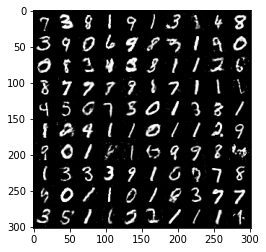

In [21]:
from torchvision.utils import make_grid

#Load saved model
generator = Generator(input_size=64, output_size=784, hidden_size=256)
generator.load_state_dict(torch.load('generator.pt'))
generator.eval()

#Generate fake image from noise vector
noise_vector = noise_generator(100, latent_size)
fake_img = generator(noise_vector)

fake_img = denormalize(fake_img.detach().cpu().view(-1, 1, 28, 28))
fake_img = make_grid(tensor=fake_img, nrow=10).permute(1,2,0)
#fake_img: [h,w,c], just one img

plt.imshow(fake_img, cmap='gray')
plt.show()

## References

* Generative Adversarial Nets [Goodfellow et al., 2014]: https://arxiv.org/pdf/1406.2661.pdf
* https://www.kaggle.com/kmldas/mnist-generative-adverserial-networks-in-pytorch